In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, PReLU, Input, Reshape, Layer, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import numpy as np
from astropy.io import fits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter1d

def build_encoder(input_shape, latent_dim):
    input_layer = Input(shape=input_shape)

    # Convolutional Layers
    x = Conv1D(filters=128, kernel_size=5, padding='valid', name='conv1')(input_layer)
    x = PReLU(name='prelu1')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool1')(x)

    x = Conv1D(filters=256, kernel_size=11, padding='valid', name='conv2')(x)
    x = PReLU(name='prelu2')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool2')(x)

    x = Conv1D(filters=512, kernel_size=21, padding='valid', name='conv3')(x)
    x = PReLU(name='prelu3')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool3')(x)

    # Flatten the output from Conv layers
    x = Flatten(name='flatten')(x)

    # Fully Connected Layers
    x = Dense(256, name='dense1')(x)
    x = PReLU(name='prelu4')(x)
    x = Dense(128, name='dense2')(x)
    x = PReLU(name='prelu5')(x)
    x = Dense(64, name='dense3')(x)
    x = PReLU(name='prelu6')(x)

    # Latent Space
    latent_space = Dense(latent_dim, name='latent_space')(x)

    return Model(input_layer, latent_space, name='encoder')

# This version compiles but has run time issues. 
'''
def build_decoder(latent_dim, output_dim, rest_range, observed_range, observed_resolution, upsample_factor):
    # Inputs: latent vector and scalar z
    latent_input = Input(shape=(latent_dim,), name='latent_input')
    z_input = Input(shape=(1,), name='z')  # Scalar input for z
    
    # Step 1: Fully Connected Layers to generate rest frame representation
    x = Dense(64)(latent_input)
    x = PReLU()(x)    
    x = Dense(256)(x)
    x = PReLU()(x)
    x = Dense(1024)(x)
    x = PReLU()(x)

    # Generate rest frame grid
    min_rest_x, max_rest_x = rest_range
    rest_length = int((max_rest_x - min_rest_x) / observed_resolution * upsample_factor)
    rest_x = tf.linspace(min_rest_x, max_rest_x, rest_length)

    # Upsample Layer 
    x = Dense(rest_length)(x)
    x = PReLU()(x)

    # Define a Lambda layer to handle TensorFlow operations on Keras tensors
    def slice_and_downsample(inputs):
        x, z_input = inputs

        # Compute Boundary Indexes based on rest_x, observed_range, and z_input
        min_rest_obs = observed_range[0] / (1 + z_input)
        max_rest_obs = observed_range[1] / (1 + z_input)

        # Find start and stop indices using TensorFlow operations
        start_index = tf.argmin(tf.abs(rest_x - min_rest_obs))
        stop_index = tf.argmin(tf.abs(rest_x - max_rest_obs))

        # Slice and downsample the tensor
        sliced_x = x[:, start_index:stop_index]

        # Ensure downsampling results in `output_dim` elements
        downsample_factor = tf.cast(tf.shape(sliced_x)[1] / output_dim, tf.int32)
        output = sliced_x[:, ::downsample_factor]

        return output

    # Define the output shape manually
    def compute_output_shape(input_shapes):
        latent_shape, z_shape = input_shapes
        return (latent_shape[0], output_dim)

    # Use Lambda layer to apply the slicing and downsampling
    output = Lambda(slice_and_downsample, output_shape=compute_output_shape)([x, z_input])

    # Reshape the final output to the desired dimensions
    output = Reshape((output_dim, 1))(output)

    return Model([latent_input, z_input], output, name='decoder')
'''

def build_decoder(latent_dim, output_dim, rest_range, observed_range, observed_resolution, upsample_factor):
    # Inputs: latent vector and scalar z
    latent_input = Input(shape=(latent_dim,), name='latent_input')
    z_input = Input(shape=(1,), name='z')  # Scalar input for z
    
    # Step 1: Fully Connected Layers to generate rest frame representation
    x = Dense(64)(latent_input)
    x = PReLU()(x)    
    x = Dense(256)(x)
    x = PReLU()(x)
    x = Dense(1024)(x)
    x = PReLU()(x)

    # Generate rest frame grid
    min_rest_x, max_rest_x = rest_range
    rest_length = int((max_rest_x - min_rest_x) / observed_resolution * upsample_factor)
    rest_x = tf.linspace(min_rest_x, max_rest_x, rest_length)

    # Upsample Layer 
    x = Dense(rest_length)(x)
    x = PReLU()(x)

    # Define a Lambda layer to handle TensorFlow operations on Keras tensors
    def slice_and_downsample(inputs):
        x, z_input = inputs

        # Compute Boundary Indexes based on rest_x, observed_range, and z_input
        z_input = tf.squeeze(z_input, axis=-1)  # Remove the extra dimension from z_input if needed
        min_rest_obs = observed_range[0] / (1 + z_input)
        max_rest_obs = observed_range[1] / (1 + z_input)

        # Broadcast rest_x to match the batch size (the first dimension of x)
        rest_x_broadcasted = tf.broadcast_to(rest_x, [tf.shape(x)[0], rest_length])

        # Find start and stop indices using TensorFlow operations
        start_indices = tf.argmin(tf.abs(rest_x_broadcasted - tf.expand_dims(min_rest_obs, axis=-1)), axis=-1)
        stop_indices = tf.argmin(tf.abs(rest_x_broadcasted - tf.expand_dims(max_rest_obs, axis=-1)), axis=-1)

        # Use TensorFlow's batch-wise slicing mechanism to slice based on indices
        batch_size = tf.shape(x)[0]

        # Generate index grid for each batch
        indices = tf.range(batch_size)

        # Gather the slice from each batch using start and stop indices
        sliced_x = tf.map_fn(
            lambda idx: x[idx, start_indices[idx]:stop_indices[idx]:upsample_factor], 
            indices, dtype=tf.float32
        )

        return sliced_x

    # Define the output shape manually
    def compute_output_shape(input_shapes):
        latent_shape, z_shape = input_shapes
        return (latent_shape[0], output_dim)

    # Use Lambda layer to apply the slicing and downsampling
    output = Lambda(slice_and_downsample, output_shape=compute_output_shape)([x, z_input])

    # Reshape the final output to the desired dimensions
    output = Reshape((output_dim, 1))(output)

    return Model([latent_input, z_input], output, name='decoder')
def build_autoencoder(input_shape, latent_dim, z_range, observed_range, observed_resolution, upsample_factor):
    spectra_input = Input(shape=input_shape, name='spectra_input')
    
    # Building the encoder (you would define build_encoder separately)
    encoder = build_encoder(input_shape, latent_dim)
    latent_space = encoder(spectra_input)
    
    # Scalar z input for each iteration
    z_input = Input(shape=(1,), name='z_input')
    
    # Building the decoder, which now takes both latent vector and scalar z

    rest_range = [observed_range[0]/(1+z_range[1]), observed_range[1]/(1+z_range[0])]

    decoder = build_decoder(latent_dim, input_shape[0], rest_range, observed_range, observed_resolution, upsample_factor)
    reconstructed_output = decoder([latent_space, z_input])

    # Define the complete autoencoder model
    return Model(inputs=[spectra_input, z_input], outputs=reconstructed_output, name='autoencoder')

In [20]:
observed_range = [3550, 10400]
observed_length = 1500
observed_resolution = (observed_range[1]-observed_range[0])/observed_length
z_range = [1.5, 2.2]

autoencoder = build_autoencoder(input_shape=(1500, 1), latent_dim=10, z_range=z_range, observed_range=observed_range, observed_resolution=observed_resolution, upsample_factor=2)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectra_input       │ (None, 1500, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 10)        │ 26,522,634 │ spectra_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_input             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 1500, 1)   │  1,652,592 │ encoder[0][0],    │
│ (Functional)        │                   │            │ z_input[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,175,226 (107.48 MB)

 Trainable params: 28,175,226 (107.48 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter1d
from astropy.io import fits

data_dir = '/Users/tkiker/Documents/GitHub/AGN-UMAP/data/sdss_spectra'

file_names = []
spectra = []
zs = []

x = np.linspace(observed_range[0], observed_range[1], observed_length)

for file_name in os.listdir(data_dir)[0:500]:
    hdul = fits.open(os.path.join(data_dir, file_name))
    
    z = hdul[2].data['z'][0]

    if z_range[0] <= z <= z_range[1]:

        data = hdul[1].data

        wavelength = 10**data["loglam"]
        flux = data["flux"]

        # Apply a Gaussian filter to smooth the flux
        flux = gaussian_filter1d(flux, sigma=3)
        
        # Interpolate the flux to match the x array
        flux = np.interp(x, wavelength, flux)

        # Convert to rest-frame wavelength
        rest_wavelength = x / (1 + z)

        # Normalize the flux using a range of rest wavelengths
        norm_mask = np.logical_and(rest_wavelength >= 2000, rest_wavelength <= 2500)
        flux /= np.median(flux[norm_mask])

        spectra.append(flux)
        file_names.append(file_name)
        zs.append(z)

# Convert to numpy arrays
spectra = np.array(spectra)
zs = np.array(zs)
file_names = np.array(file_names)

# Split the data into training and test sets (you can adjust test_size and random_state)
spectra_train, spectra_test, zs_train, zs_test, file_names_train, file_names_test = train_test_split(
    spectra, zs, file_names, test_size=0.2, random_state=42
)

print("Training set size:", len(spectra_train))
print("Test set size:", len(spectra_test))

Training set size: 392
Test set size: 99


In [21]:
# Train the model using the `fit` method
history = autoencoder.fit(
    [spectra_train, zs_train],  # Training data for both inputs
    spectra_train,              # The target output is the same as the input in autoencoders
    epochs=50,                  # Number of epochs to train
    batch_size=32,              # Size of each batch
    validation_data=([spectra_test, zs_test], spectra_test),  # Validation data
    verbose=1                   # Show training progress
)

# After training, you can evaluate the model on the test set or save the model
autoencoder.save('autoencoder_model.h5')

Epoch 1/50
Instructions for updating:
Use fn_output_signature instead


TypeError: Exception encountered when calling Lambda.call().

[1mTensors in list passed to 'values' of 'Pack' Op have types [int32, int64] that don't all match.[0m

Arguments received by Lambda.call():
  • inputs=['tf.Tensor(shape=(None, 1336), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)']
  • mask=['None', 'None']
  • training=True

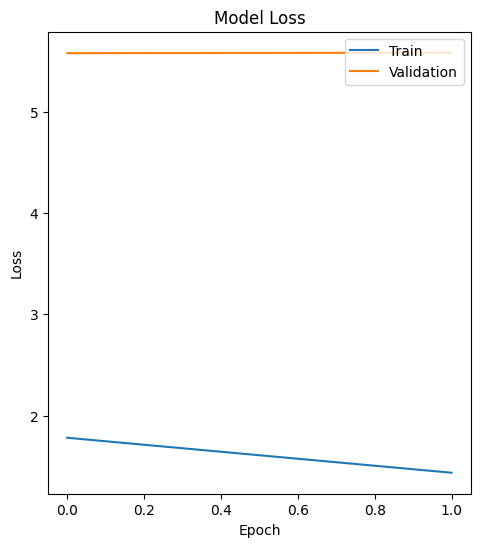

In [6]:
# Plot the training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Show the plots
plt.show()